In [ ]:
#Esse notebook tem o objetivo de fazer uma análise de emoções em frases em inglês
#Fonte dos dados: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
!pip install wordcloud

In [30]:
pip install imbalanced-learn

     -------------------------------------- 258.3/258.3 kB 8.0 MB/s eta 0:00:00
     -------------------------------------- 301.8/301.8 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
df_treino = pd.read_csv("dataset/train.csv")
df_teste = pd.read_csv("dataset/test.csv")
df_val = pd.read_csv("dataset/val.csv")

In [3]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     16000 non-null  object
 1   emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [4]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [5]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [6]:
classes = df_treino['emotion'].unique()
print("Classes presentes: ",classes)

print("Quantidade de cada emoção: \n", df_treino['emotion'].value_counts())

percentual_emotion = (df_treino['emotion'].value_counts() / len(df_treino)) * 100
print("Porcentagem de cada emoção: \n",percentual_emotion)

Classes presentes:  ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']
Quantidade de cada emoção: 
 joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64
Porcentagem de cada emoção: 
 joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: emotion, dtype: float64


In [7]:
print("Quantidade de cada emoção validação: \n", df_val['emotion'].value_counts())

percentual_emotion = (df_val['emotion'].value_counts() / len(df_val)) * 100
print("Porcentagem de cada emoção validação: \n", percentual_emotion)

Quantidade de cada emoção validação: 
 joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: emotion, dtype: int64
Porcentagem de cada emoção validação: 
 joy         35.20
sadness     27.50
anger       13.75
fear        10.60
love         8.90
surprise     4.05
Name: emotion, dtype: float64


In [8]:
print("Quantidade de cada emoção teste: \n", df_teste['emotion'].value_counts())

percentual_emotion = (df_teste['emotion'].value_counts() / len(df_teste)) * 100
print("Porcentagem de cada emoção validação: \n", percentual_emotion)

Quantidade de cada emoção teste: 
 joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: emotion, dtype: int64
Porcentagem de cada emoção validação: 
 joy         34.75
sadness     29.05
anger       13.75
fear        11.20
love         7.95
surprise     3.30
Name: emotion, dtype: float64


As categorias "joy" e "sadness" possuem um número maior de amostras comparada as outras categorias, isso pode causar um desequilibrio de amostras quando for treinar o modelo. O modelo pode ficar tendencioso a rotular a maioria dos textos como "joy" e "sadness". Para evitar isso, será usado UnderSampling nas amostras com essas categorias, diminuindo 3000 amostras.

In [9]:
X = df_treino['text'].values.reshape(-1, 1)  
y = df_treino['emotion']  

contagem_original = y.value_counts()
print("Antes do undersampling:\n", contagem_original)

nova_contagem = contagem_original.copy()
nova_contagem['joy'] -= 3000  
nova_contagem['sadness'] -= 3000  

undersampler = RandomUnderSampler(sampling_strategy=nova_contagem.to_dict(), random_state=42)

X_resampled, y_resampled = undersampler.fit_resample(X, y)

df_treino_balanceado = pd.DataFrame({'text': X_resampled.flatten(), 'emotion': y_resampled})

print("Depois do undersampling:\n", df_treino_balanceado['emotion'].value_counts())

Antes do undersampling:
 joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64
Depois do undersampling:
 joy         2362
anger       2159
fear        1937
sadness     1666
love        1304
surprise     572
Name: emotion, dtype: int64


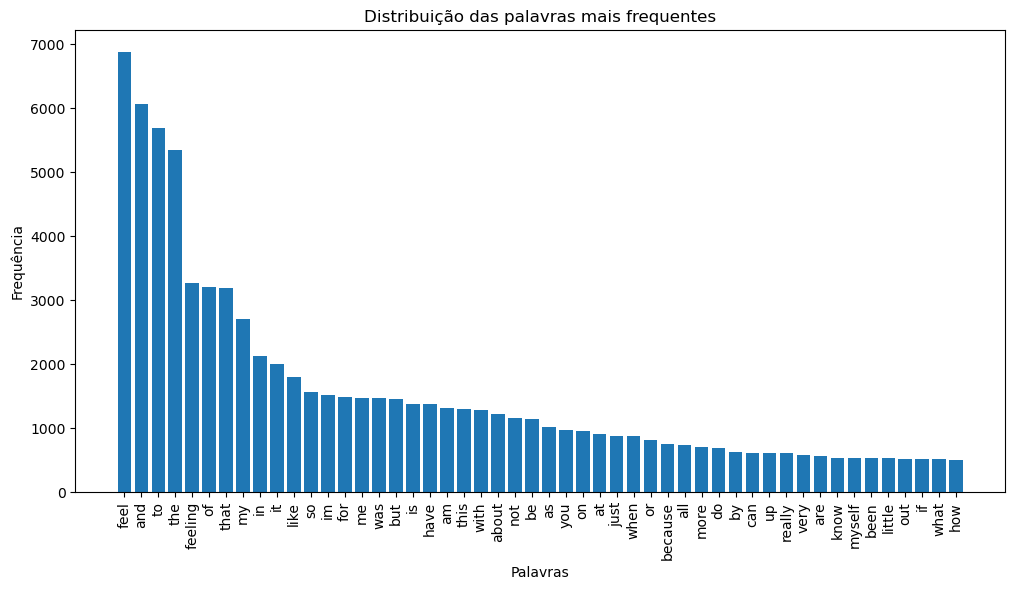

In [14]:
# Converte o texto em bag-of-words (frequência de palavras)
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df_treino_balanceado['text'])
word_counts = X_counts.toarray().sum(axis=0)

# Ordena as palavras pela frequência
words_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
words_freq_sorted = sorted(words_freq.items(), key=lambda x: x[1], reverse=True)

# Plota as 50 palavras mais frequentes
plt.figure(figsize=(12, 6))
plt.bar([word[0] for word in words_freq_sorted[:50]], [word[1] for word in words_freq_sorted[:50]])
plt.xticks(rotation=90)
plt.xlabel("Palavras")
plt.ylabel("Frequência")
plt.title("Distribuição das palavras mais frequentes")
plt.show()


#### Pré-processamento do texto

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')  # Necessário para a tokenização

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    #Garante que os textos estarão em minusculas
    text = text.lower()
    #remove núrmeros se houver
    text = re.sub(r'\d+', '', text)
    #remove pontuações
    text = text.translate(str.maketrans('', '', string.punctuation))
    #Transforma os textos em tokens
    tokens = word_tokenize(text)
    #Remove stop_words e lemantiza
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
treino = df_treino_balanceado['text'].apply(preprocess_text)
teste = df_teste['text'].apply(preprocess_text)
val = df_teste['text'].apply(preprocess_text)

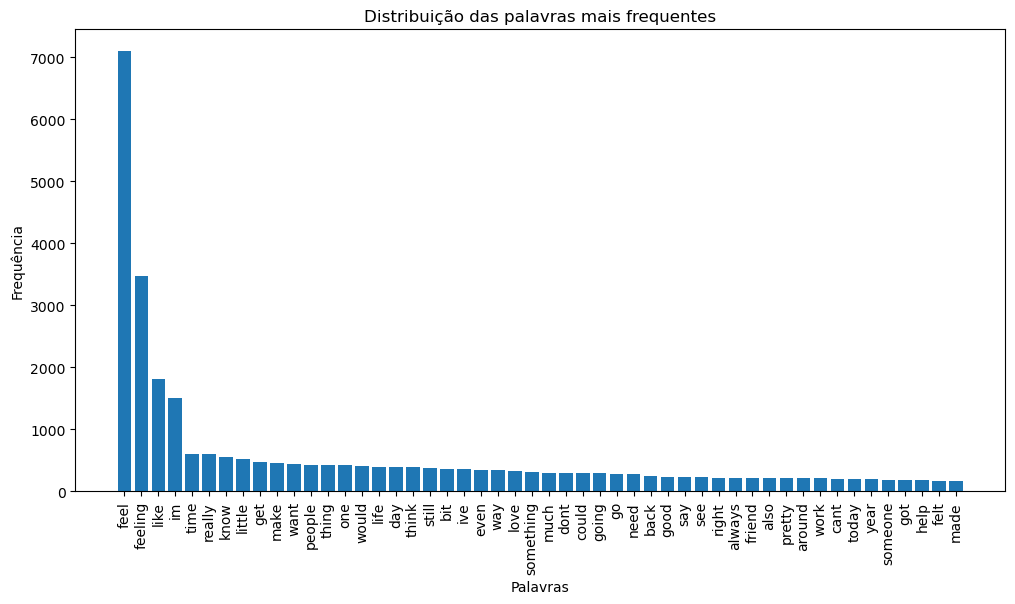

In [16]:
# Converte o texto em bag-of-words (frequência de palavras)
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(treino)
word_counts = X_counts.toarray().sum(axis=0)

# Ordena as palavras pela frequência
words_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
words_freq_sorted = sorted(words_freq.items(), key=lambda x: x[1], reverse=True)

# Plota as 50 palavras mais frequentes
plt.figure(figsize=(12, 6))
plt.bar([word[0] for word in words_freq_sorted[:50]], [word[1] for word in words_freq_sorted[:50]])
plt.xticks(rotation=90)
plt.xlabel("Palavras")
plt.ylabel("Frequência")
plt.title("Distribuição das palavras mais frequentes")
plt.show()


#### Nuvem de palavras

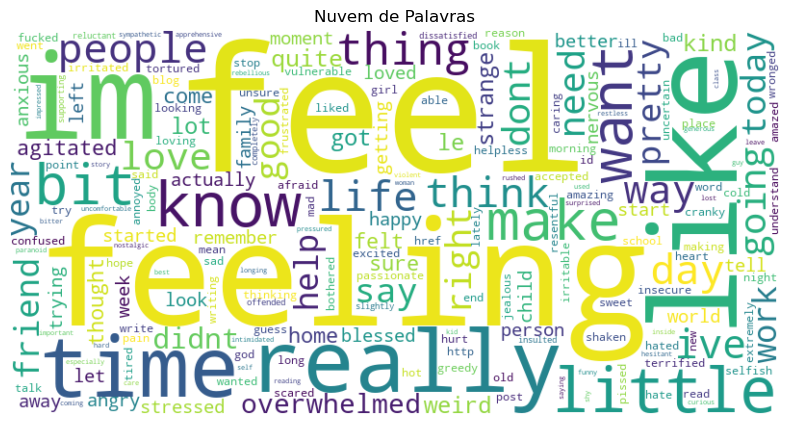

In [17]:
# Vetoriza os textos para obter a frequência das palavras
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(treino)

# Obtém a frequência das palavras
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))

# Gera a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(word_freq)

# Exibe a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras")
plt.show()


#### Vetorização (TF-IDF + bigrams) 

In [18]:
# Vetorização usando bigrans
vectorizer = TfidfVectorizer(max_features = 4296, ngram_range=(2, 2))
treino_tfidf_balanceado = vectorizer.fit_transform(treino)
val_tfidf = vectorizer.fit_transform(val)
teste_tfidf = vectorizer.fit_transform(teste)

print(vectorizer.get_feature_names_out())

['abandoned little' 'able cook' 'able give' ... 'yesterday feel'
 'young people' 'youve made']


#### Treinando o modelo Naive Bayes

In [20]:
classes_treino_balanceado = df_treino_balanceado['emotion']
model = MultinomialNB()
model.fit(treino_tfidf_balanceado , classes_treino_balanceado)

MultinomialNB()

In [21]:
#Treino
pred_treino = model.predict(treino_tfidf_balanceado)
accuracy_treino = accuracy_score(classes_treino_balanceado, pred_treino)
print(f"Acurácia no conjunto de treino após balanceamento: {accuracy_treino:.4f}")
print(classification_report(classes_treino_balanceado, pred_treino))

Acurácia no conjunto de treino após balanceamento: 0.7837
              precision    recall  f1-score   support

       anger       0.80      0.84      0.82      2159
        fear       0.80      0.83      0.81      1937
         joy       0.66      0.93      0.77      2362
        love       0.94      0.64      0.76      1304
     sadness       0.93      0.72      0.81      1666
    surprise       1.00      0.33      0.49       572

    accuracy                           0.78     10000
   macro avg       0.85      0.71      0.74     10000
weighted avg       0.82      0.78      0.78     10000



In [22]:
#Validação após balanceamento
classes_val = df_val['emotion']
pred_val = model.predict(val_tfidf)
accuracy_val = accuracy_score(classes_val, pred_val)
print(f"Acurácia no conjunto de validação: {accuracy_val:.4f}")
print(classification_report(classes_val, pred_val))

Acurácia no conjunto de validação: 0.2180
              precision    recall  f1-score   support

       anger       0.13      0.27      0.17       275
        fear       0.11      0.20      0.14       212
         joy       0.36      0.34      0.35       704
        love       0.10      0.07      0.08       178
     sadness       0.26      0.12      0.17       550
    surprise       0.00      0.00      0.00        81

    accuracy                           0.22      2000
   macro avg       0.16      0.17      0.15      2000
weighted avg       0.24      0.22      0.22      2000



In [24]:
#Teste
classes_teste = df_teste['emotion']
pred_teste = model.predict(teste_tfidf)
accuracy_teste = accuracy_score(classes_teste, pred_teste)
print(f"Acurácia no conjunto de teste: {accuracy_teste:.4f}")
print(classification_report(classes_teste, pred_teste))

Acurácia no conjunto de teste: 0.2215
              precision    recall  f1-score   support

       anger       0.14      0.29      0.19       275
        fear       0.11      0.18      0.13       224
         joy       0.36      0.35      0.35       695
        love       0.07      0.05      0.06       159
     sadness       0.29      0.13      0.18       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.22      2000
   macro avg       0.16      0.17      0.15      2000
weighted avg       0.25      0.22      0.22      2000



O modelo no conjunto de dados de treino apresentou uma acurácia de 78.37%. Mas obteve uma queda drástica na validação(21.8%) e teste (22.15%), que significa que o modelo está memorizando o conjunto de dados de treino e não generalizando bem novos dados, ou seja, o modelo está com Overfitting.
Motivos que podem estar causando isso:
- As classes "love" e "surprise" têm recall muito baixo, que indica que o modelo tem dificuldade em identificalos corretamente. Isso pode estar sendo causado pois essas classes têm poucas amostras de "surprise"(572 no treino, 66 no teste) e "love" (1304 no treino, 159 no teste). Em contrapartida, o modelo tende a classificar considerando as classes majoritarias "joy" (2362 amostras), anger (2159) e fear (1937), logo dificultando um aprendizado equilibrado.

Possíveis Causas:
- Modelo simples: O Naive Bayes assume independência entre as características, o que pode não ser ideal para capturar nuances emocionais em textos.

- Representação TF-IDF + bigrams pode não ser suficiente: O modelo pode estar capturando padrões muito específicos dos dados de treino.

- Dados desbalanceados anteriormente: O balanceamento pode não ter sido feito corretamente ou pode ter removido informações importantes.

- Bigramas podem estar superajustando o modelo: Se os bigramas usados forem muito específicos do conjunto de treino, podem não generalizar bem.

#### Alternativas futuras
Para tentar resolver esses problemas e melhorar o modelo, será considerado os seguintes tópicos:

1. Regularizar a vetorização TF-IDF

    -  Ajustar hiperparâmetros como max_df, min_df e max_features no TfidfVectorizer.

    -  Testar remover bigrams e usar apenas unigrams.

2. Testar um modelo mais robusto

    -  Random Forest, Logistic Regression ou mesmo um modelo baseado em redes neurais simples (MLP).

    -  Testar um modelo de deep learning como LSTMs ou Transformers pode ajudar a capturar melhor os padrões.

3. Reduzir a dimensionalidade

    -  PCA ou TruncatedSVD podem ajudar a eliminar ruídos na representação vetorial.

4. Aprimorar o pré-processamento

    -  Verificar se a remoção de stopwords, lematização ou stemming pode melhorar o desempenho.

5. Usar embeddings em vez de TF-IDF

    -  Word2Vec, FastText ou embeddings mais modernos (BERT, RoBERTa) podem capturar melhor os significados dos textos.